In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import random

import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [6,4]
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


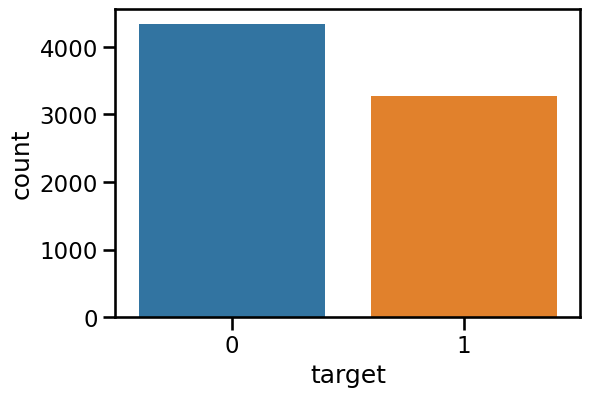

In [7]:
#check class imbalance

df_targets = df.target.value_counts().reset_index()
df_targets.columns = ['target','count']

sns.set_context("talk")

sns.barplot(x = 'target',
            y = 'count',
            data = df_targets)

plt.savefig("check_class_imbalance.png",
            bbox_inches="tight",
            dpi = 400,
           transparent=True); #avoid cutting off labels

# Show the plot
plt.show()

No severe class imbalance.

# Cleaning

In [6]:
def remove_urls(text: str, replacement: str="") -> str:
    """Removes URLs from a given string."""
    """Also removes @ mentions."""
    # Define the regex used to identify URLs
    url_expression = (
        r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)"
        r"(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s("
        r")<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    )
    # Replace any URLs with the replacement string
    text1 = re.sub(url_expression, replacement, text)
    
    #remove @ mentions and return
    return re.sub(r"@[A-Za-z0-9]+", replacement, text1)

In [7]:
def remove_nonalphanumeric(text: np.str_) -> str:
    """
    Removes non-alphanumeric characters from a given string.
    
    Preserves spaces and quotation marks (to preserve contractions).
    """

    return re.sub("[^A-Za-z0-9 '\"]+", '', text)

In [8]:
df["text"] = df["text"].apply(remove_urls) # Must be done first
df["text"] = df["text"].apply(remove_nonalphanumeric)

In [9]:
#remove irrelevant string
df['text'] = df.text.str.replace('I liked a YouTube video', '').replace('I added a video to a YouTube playlist', '')

In [10]:
df['text_lower'] = df.text.str.lower()

In [11]:
#removing duplicate tweets
df = df.drop_duplicates(subset=['text_lower'], keep='first')
df = df.reset_index(drop=True)

In [12]:
df.head()

,id,keyword,location,text,target,text_lower
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1,our deeds are the reason of this earthquake may allah forgive us all
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers No other evacuation or shelter in place orders are expected,1,all residents asked to 'shelter in place' are being notified by officers no other evacuation or shelter in place orders are expected
3,6,NaN,NaN,13000 people receive wildfires evacuation orders in California,1,13000 people receive wildfires evacuation orders in california
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1,just got sent this photo from ruby alaska as smoke from wildfires pours into a school


# Lemmatize

In [31]:
#!python -m spacy download en_core_web_sm

In [20]:
nlp = spacy.load('en_core_web_sm')
                 #, disable=['parser'])

nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [21]:
#remove stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [22]:
#Customize stop words

#stopwords = nlp.Defaults.stop_words

# print(len(stopwords))

# #add new stop words
# nlp.Defaults.stop_words.add("my_new_stopword")
#nlp.Defaults.stop_words |= {"Afham","Farden"}

# #remove stop words
# nlp.Defaults.stop_words.remove("what")
# nlp.Defaults.stop_words -= {"who", "when"}

# # # My custom list of stop words.
# stop_list = ["like"]
# # # Updates spaCy's default stop words list with my additional words. 
# nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

In [23]:
'like' in nlp.Defaults.stop_words

True

In [24]:
#remove stop word, lemmatization
def preprocess(doc):

    sent_cleaned = ''
    for token in nlp(doc):
        if not token.is_stop:
            if not token.pos_ == 'PUNCT':
                sent_cleaned += token.lemma_.lower()
                sent_cleaned += ' '
    sent_cleaned = sent_cleaned.strip()
    return sent_cleaned

In [25]:
#remove stop word, lemmatization
# processed = tqdm(tweets_df_en['CleanedText'].\
#         map(lambda x: preprocess(x)))
#         #map(lambda x: spellchecker(x)).\ not including spellchecker since it changes Elon to Leon
processed=[]
for tweet in tqdm(df['text']):
    processed.append(preprocess(tweet))

100%|██████████████████████████████████████████████████████████████████████████████| 6923/6923 [00:22<00:00, 309.31it/s]


# TF-IDF Tokenize

In [32]:
#TF-IDF
#limit max features for performance
tv = TfidfVectorizer(stop_words=None, ngram_range=(1,3), max_features=100000)
tv_out = tv.fit_transform(processed)

In [33]:
tfidf = pd.DataFrame(tv_out.toarray(), columns=tv.get_feature_names())

/home/josh_wang/anaconda3/envs/data_mining/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
tfidf.head(5)

,0011,0011 utc,0011 utc earthquake,001116,001116 utc20150805,001116 utc20150805 161116,0025,0025 update,0025 update kml,005225,...,zrnf,zss,zss vs,zss vs sws,zumiez,zumiez location,zurich,zurich swiss,zurich swiss premiere,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Naive Bayes

In [114]:
#set seed for reproducibility
seed = 1234
np.random.seed(seed)
random.seed(seed)

## Baseline

In [116]:
skf = StratifiedKFold(n_splits = 5, random_state=seed, shuffle=True)

pipeline = Pipeline([
    ('Tfid', TfidfVectorizer(stop_words=None)),
    ('clf', MultinomialNB())
])

X_train = processed
y_train = df.target

scores = cross_validate(pipeline, X_train, y_train, cv=skf, scoring='f1', return_estimator=True)

#mean BSS of lr base
np.mean(scores['test_score'])

0.6949177191801885

## GridsearchCV

In [120]:
ngram_range = [(1,2)]
max_features = np.arange(5100,5250,25)
alpha = np.arange(0.4,0.6,0.01)
fit_prior = [False]

pipeline = Pipeline([
    ('Tfid', TfidfVectorizer(stop_words=None)),
    ('clf', MultinomialNB())
])

params = [{
        'Tfid__ngram_range': ngram_range,
        'Tfid__max_features':max_features,
        'clf__alpha':alpha,
        'clf__fit_prior':fit_prior    
        }]

skf = StratifiedKFold(n_splits = 5, random_state=seed, shuffle=True)

model = GridSearchCV(pipeline, param_grid = params, scoring = 'f1', cv=skf, n_jobs=-1, verbose=1)

X_train = processed
y_train = df.target

model.fit(X_train, y_train)
#y_pred_gs=gs_lr.predict(X_test)

print(model.best_params_)
print(model.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'Tfid__max_features': 5200, 'Tfid__ngram_range': (1, 2), 'clf__alpha': 0.44000000000000006, 'clf__fit_prior': False}
0.7292540666247529


In [145]:
example = ['sky is burning', 'ground is shaking', 'let us get lunch']

In [146]:
model.predict(example)

array([1, 1, 0])